In [1]:
import torch
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

from dataloader.NYU import labeled as nyuv2_labeled
from dataloader.ARKitScenes import labeled as ARkitScenes_labeled
from dataloader.DDFF12 import loader as DDFF12_loader
from dataloader.Matterport3D import loader as Matterport3D_loader

from utils.synthetic import camera_lib


In [2]:
from PIL import Image


def show_img(img: np.ndarray, is_hdr: bool = False):
    """Show image in jupyter notebook using PIL."""

    if is_hdr:
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)

    if len(img.shape) == 4:
        img = np.concatenate(list(img), axis=1)

    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    
    
    return Image.fromarray(img)

# DDFF12

In [3]:
dataset_ddff = DDFF12_loader.DDFF12Loader("/home/ashkanganj/workspace/dataset/dff_trainVal.h5", stack_key="stack_val",
                disp_key="disp_val",n_stack=5,
                min_disp=0.02,
                max_disp=0.28,
                b_test=True)

In [4]:
rgb_aif, focal_stack, depth_gt,focus_dist, mask = dataset_ddff[98] 

mean:  0.4451871
std:  0.19858772
------
mean:  0.4451887
std:  0.1991647
------
mean:  0.4451974
std:  0.19960073
------
mean:  0.4451878
std:  0.19988684
------
mean:  0.44514188
std:  0.19992581
------


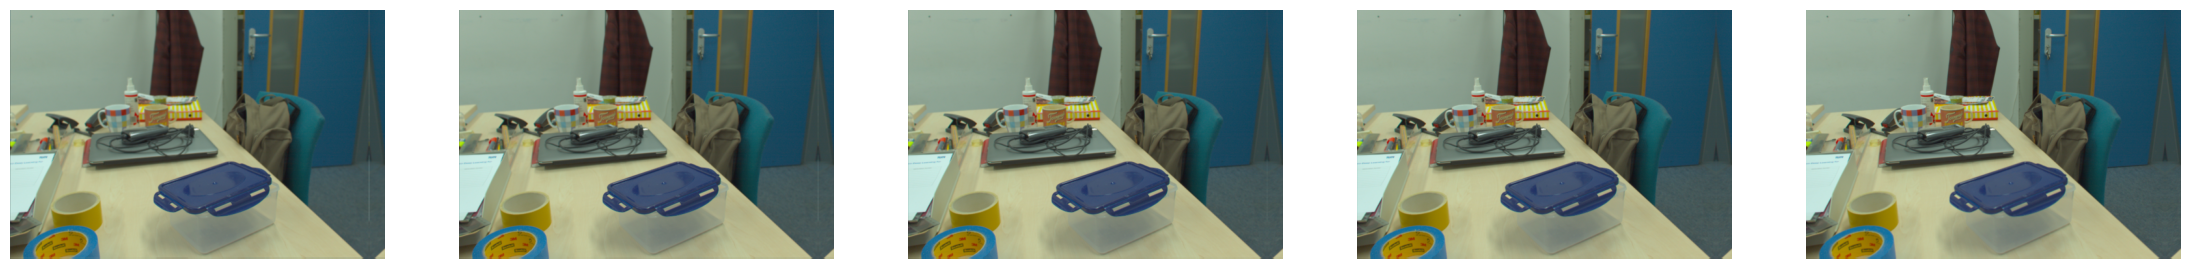

In [5]:
# Normalization parameters
mean_input = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std_input = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

# Function to denormalize a tensor
def denormalize(tensor, mean, std):
    return tensor.mul(std).add(mean)

# Denormalizing the focal stack
denormalized_stack = denormalize(focal_stack, mean_input, std_input)


# Displaying the images
fig, ax = plt.subplots(1, 5, figsize=(28, 8))
for i in range(denormalized_stack.shape[0]):
    img = denormalized_stack[i].permute(1, 2, 0).numpy() 
    # print mean and std
    print("mean: ", np.mean(img))
    print("std: ", np.std(img))
    print("------")
    ax[i].imshow(np.clip(img, 0, 1))  
    ax[i].axis('off') 

# NYU 

In [3]:
render = camera_lib.GaussPSF(32)
render.cuda()


dataset_nyu = nyuv2_labeled.NYUv2LabeledDataset(
    "/home/ashkanganj/workspace/dataset/nyu_depth_v2_labeled.mat"
)

In [4]:
@interact(
    data_idx=IntSlider(min=0, max=len(dataset_nyu), value=0, step=1),
    focus_distance=FloatSlider(
        min=0.1, max=4, value=1.0, step=0.001, readout_format=".3f"
    ),
)

def visualize_defocus(data_idx=0, focus_distance=0.1):
    rgb, depth = dataset_nyu[data_idx]
    rgb = rgb / 255.0

    res = camera_lib.render_defocus(rgb, depth, camera, render, [focus_distance])
    res = res[0].numpy().transpose(1, 2, 0)
    print("mean: ", np.mean(res))
    print("std: ", np.std(res))
    return show_img(res)

interactive(children=(IntSlider(value=0, description='data_idx', max=1449), FloatSlider(value=1.0, description…

# ARKitScenes

In [6]:
render = camera_lib.GaussPSF(32)
render.cuda()

camera = camera_lib.ThinLenCamera(img_size=560)
# camera = camera_lib.ThinLenCamera(fnumber=1.8, focal_length=3.3 * 1e-3, sensor_size=4.8 * 1e-3, img_size=1440)


dataset = Matterport3D_loader.Matterport3dDataset(
    "/mnt/IRONWOLF2/yiqinzhao/Matterport3D/v1/scans/",
            stage='test'
        )


In [7]:
@interact(
    data_idx=IntSlider(min=0, max=len(dataset), value=0, step=1),
    focus_distance=FloatSlider(
        min=0.1, max=16, value=1.0, step=0.001, readout_format=".3f"
    ),
)
def visualize_defocus(data_idx=0, focus_distance=0.1):
    rgb, depth = dataset[data_idx]

    rgb = rgb / 255.0

    res = camera_lib.render_defocus(rgb, depth, camera, render, [focus_distance])
    res = res[0].numpy().transpose(1, 2, 0)

    return show_img(res)

interactive(children=(IntSlider(value=0, description='data_idx', max=474), FloatSlider(value=1.0, description=…

# ARKitScese

In [ ]:
render = camera_lib.GaussPSF(32)
render.cuda()

camera = camera_lib.ThinLenCamera(img_size=560)
# camera = camera_lib.ThinLenCamera(fnumber=1.8, focal_length=3.3 * 1e-3, sensor_size=4.8 * 1e-3, img_size=1440)


dataset = ARkitScenes_labeled.ARKitscenesDataset(
    "/mnt/IRONWOLF1/ashkan/data/ARKitScenes/upsampling",
            stage='Validation'
        )


In [ ]:
@interact(
    data_idx=IntSlider(min=0, max=len(dataset), value=0, step=1),
    focus_distance=FloatSlider(
        min=0.1, max=10, value=1.0, step=0.001, readout_format=".3f"
    ),
)
def visualize_defocus(data_idx=0, focus_distance=0.1):
    rgb, depth = dataset[data_idx]

    rgb = rgb / 255.0

    res = camera_lib.render_defocus(rgb, depth, camera, render, [focus_distance])
    res = res[0].numpy().transpose(1, 2, 0)

    return show_img(res)